# **Thư viện**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

# **Dữ liệu**

In [3]:
df = pd.read_csv("../data/raw/EUR_VND_Exchange_Rate.csv")
df.head()

,Date,Buy,Transfer,Sell
0,2020-04-01,25297.47,25553.00,26506.55
1,2020-04-02,25297.47,25553.00,26506.55
2,2020-04-03,24742.47,24992.39,25936.23
3,2020-04-04,24742.47,24992.39,25936.23
4,2020-04-05,24742.47,24992.39,25936.23


# **`timestamp` thành index**

In [4]:
df['Date'] = pd.to_datetime(df['Date'])

df = df.set_index('Date')

df.head()

,Buy,Transfer,Sell
Date,,,
2020-04-01,25297.47,25553.00,26506.55
2020-04-02,25297.47,25553.00,26506.55
2020-04-03,24742.47,24992.39,25936.23
2020-04-04,24742.47,24992.39,25936.23
2020-04-05,24742.47,24992.39,25936.23


# **Trống, thiếu?**

**Trống**

In [5]:
missing_values = df.isnull().sum()
print("Số lượng giá trị trống trong mỗi cột:\n", missing_values)

Số lượng giá trị trống trong mỗi cột:
 Buy         0
Transfer    0
Sell        0
dtype: int64


**Những ngày thiếu**

In [6]:
full_range = pd.date_range(start='2020-04-01', end='2025-04-01', freq='D')

existing_dates = df.index

missing_dates = full_range.difference(existing_dates)

if missing_dates.empty:
    print("Không có ngày nào bị thiếu trong dữ liệu.")
else:
    print("Các ngày bị thiếu trong dữ liệu:")
    print(missing_dates.strftime('%Y-%m-%d').tolist())
    print(len(missing_dates))


Không có ngày nào bị thiếu trong dữ liệu.


Thiếu do nghỉ lễ, T7/CN

In [7]:
len(df)

1837

# **Trùng ngày**

In [8]:
duplicate_dates = df.index[df.index.duplicated(keep=False)]
print(len(df))
print(df.loc[duplicate_dates])

1837
Empty DataFrame
Columns: [Buy, Transfer, Sell]
Index: []


# **Ma trận tương quan**

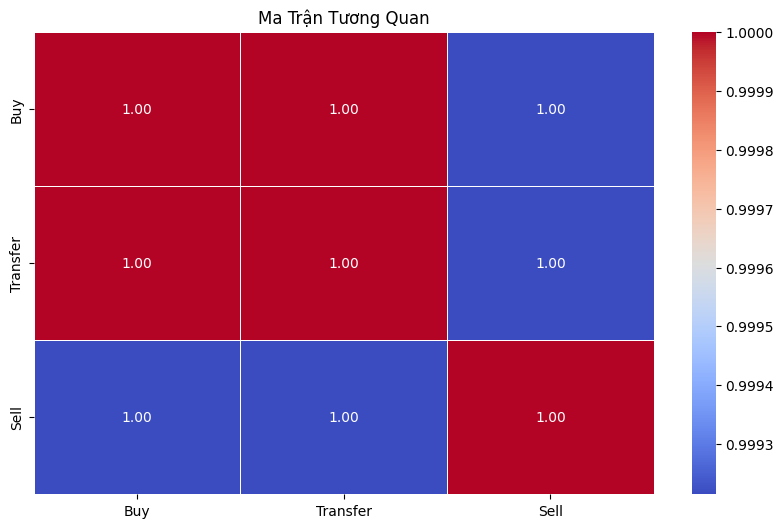

In [9]:
corr_matrix = df.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Ma Trận Tương Quan")
plt.show()

=> Chỉ chọn "Sell"

In [10]:
data = df['Sell']

# **Thống kê dữ liệu, IQR**

In [11]:
data.describe()

count     1837.000000
mean     26998.724573
std       1187.634585
min      23399.490000
25%      26204.510000
50%      27086.350000
75%      28017.460000
max      29775.690000
Name: Sell, dtype: float64

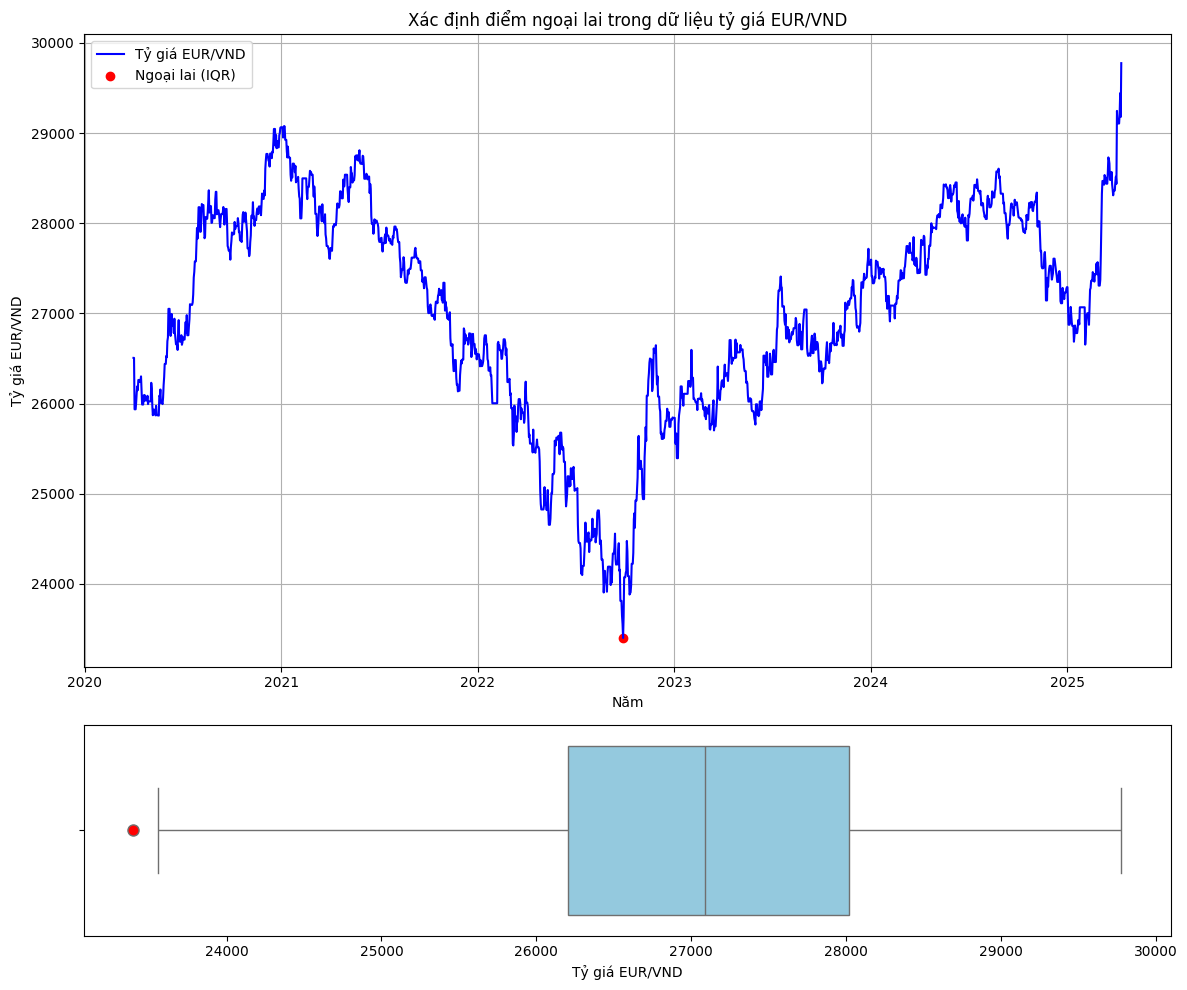

In [12]:

prices = data

prices = prices[prices > 0]

Q1 = prices.quantile(0.25)
Q3 = prices.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = (prices < lower_bound) | (prices > upper_bound)

fig, ax = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [3, 1]})

# 1. Line plot + đánh dấu ngoại lai
ax[0].plot(prices.index, prices, label="Tỷ giá EUR/VND", color="blue")
ax[0].scatter(prices.index[outliers], prices[outliers], color="red", label="Ngoại lai (IQR)")
ax[0].set_xlabel("Năm")
ax[0].set_ylabel("Tỷ giá EUR/VND")
ax[0].set_title("Xác định điểm ngoại lai trong dữ liệu tỷ giá EUR/VND")
ax[0].legend()
ax[0].grid()

# 2. Boxplot để trực quan hóa ngoại lai
sns.boxplot(x=prices, ax=ax[1], color="skyblue", flierprops={'marker': 'o', 'markerfacecolor': 'red', 'markersize': 8})
ax[1].set_xlabel("Tỷ giá EUR/VND")

plt.tight_layout()
plt.show()

In [13]:
prices[outliers]

Date
2022-09-28    23399.49
Name: Sell, dtype: float64

<Figure size 1400x1000 with 0 Axes>

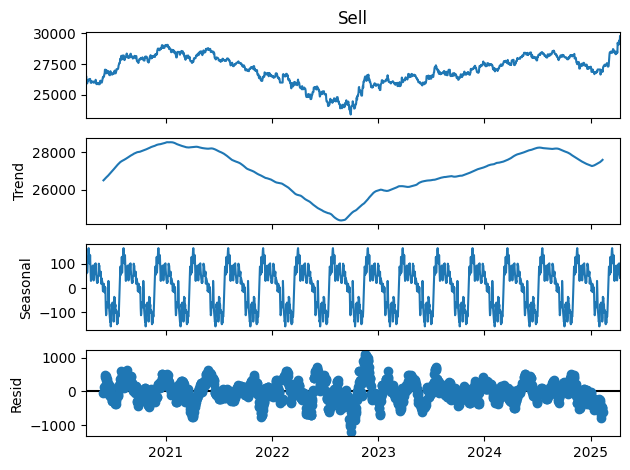


Kiểm tra tính dừng cho Sell rate sau khi lấy sai phân:


In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Phân tích thành phần của chuỗi thời gian
decomposition = seasonal_decompose(df['Sell'], model='additive', period=120)
plt.figure(figsize=(14, 10))
decomposition.plot()
plt.tight_layout()
plt.show()

# Tạo chuỗi dừng bằng cách lấy sai phân bậc 1
df_diff = df.diff().dropna()

# Kiểm tra lại tính dừng sau khi lấy sai phân
print("\nKiểm tra tính dừng cho Sell rate sau khi lấy sai phân:")
# check_stationarity(df_diff['Sell'])


<Figure size 1400x1000 with 0 Axes>

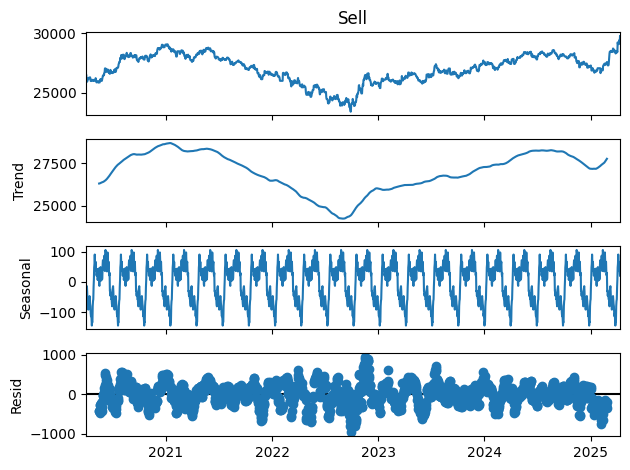

In [19]:
y = df['Sell']

decomposition = seasonal_decompose(y, model='additive', period=90) 
plt.figure(figsize=(14, 10))
decomposition.plot()
plt.tight_layout()
plt.show()

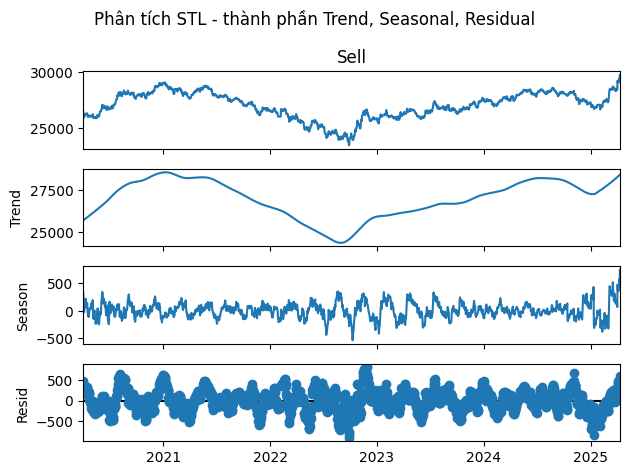

In [20]:
from statsmodels.tsa.seasonal import STL

# Chạy STL để phân tích
stl = STL(df['Sell'], period=90)  
res = stl.fit()

# Vẽ các thành phần
res.plot()
plt.suptitle('Phân tích STL - thành phần Trend, Seasonal, Residual')
plt.tight_layout()
plt.show()

# **Lưu dữ liệu**

In [ ]:
data.to_csv("../data/processed/EUR_VND_Exchange_Rate.csv")